# Assignment 2: Emotion Classification

In this assignment, we trained three models for emotional classification. The data was provided. In the following sections, preprocessing, feature engineering, and model training and result evaluation will be demonstrated. 

For the code, we first import all necessary dependencies. 

In [140]:
#all dependencies

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import wordpunct_tokenize

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

[nltk_data] Downloading package stopwords to /Users/ygao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ygao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Then, we set up our constraints. 

In [26]:
#constants
DATA_LOCATION = '../data/train_ready_for_WS.csv'
TEST_LOCATION = '../data/test.csv'
CLEAN_DATA_LOCATION = '../data/'
MODEL_LOCATION = '../model/'
RANDOM_SEED = 297
CATEGORIES = {'anger':0, 'disgust':1, 'fear':2, 'joy':3, 'neutral':4, 'sadness':5, 'surprise':6}


# Data preparation

We load the data from local source. There are training data and testing data pre-split. We then split the training data into train and validation. The corpus and target are also split up for further data augmentation.

In [27]:
#load dataset
def load_data(filename):
    df = pd.read_csv(filename, delimiter=';')
    return df

df_train = load_data(DATA_LOCATION)
df_test = load_data(TEST_LOCATION)

In [28]:
#split training dataset into train, validation (70-30)

df_train, df_val = train_test_split(df_train, test_size=0.3, random_state=RANDOM_SEED)
#reset indices
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
#save the split data frames to csv just in case
df_train.to_csv(CLEAN_DATA_LOCATION+'raw_train.csv', index=False)
df_val.to_csv(CLEAN_DATA_LOCATION+'raw_val.csv', index=False)
df_test.to_csv(CLEAN_DATA_LOCATION+'raw_test.csv', index=False)

We have a closer look at the training set to see if the data is balanced. As it turns out the data contains a lot of sadness essays. There are several ways to deal with this class imbalance. We could downsample the overrepresented class; we could also augment the data and oversample the underrepresented classes. Attempts of these will show below. 

Possible sentiments are ['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise'] of 7 sentiments
The number of posts for training is 1302


/var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/ipykernel_27557/2703198721.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotions_count.index, y=emotions_count.values,palette='viridis')


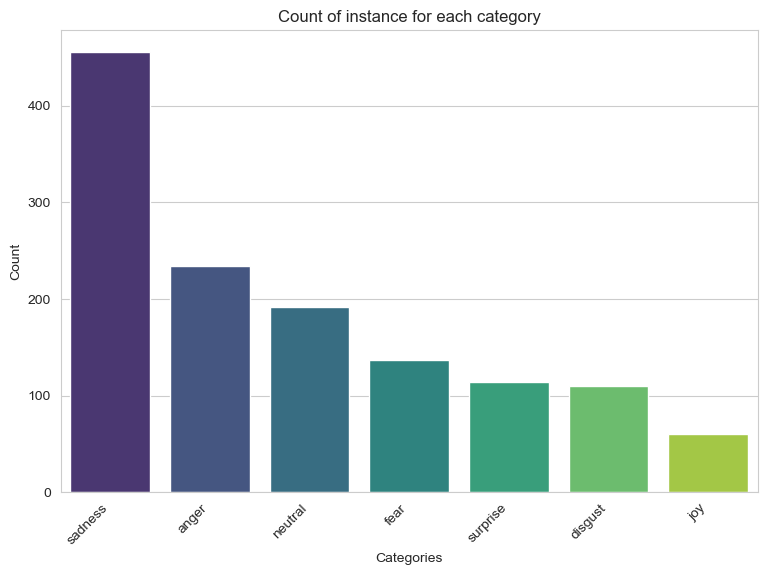

In [66]:
print("Possible sentiments are", np.unique(df_train['emotion']), "of", len(np.unique(df_train['emotion'])),"sentiments")
print("The number of posts for training is", len(df_train))

emotions_count = df_train['emotion'].value_counts()

plt.figure(figsize=(9, 6))
sns.barplot(x=emotions_count.index, y=emotions_count.values,palette='viridis')
plt.title('Count of instance for each category')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

#split into corpus and target, making target onehot encoded

label_encoder = LabelEncoder()

corpus_train = df_train['essay']
train = label_encoder.fit_transform(df_train['emotion'])
target_train = to_categorical(train, num_classes=len(CATEGORIES))

corpus_val = df_val['essay']
val = label_encoder.fit_transform(df_val['emotion'])
target_val = to_categorical(val, num_classes=len(CATEGORIES))

corpus_test = df_test['essay']
test = label_encoder.fit_transform(df_test['emotion'])
target_test = to_categorical(test, num_classes=len(CATEGORIES))

There are 1302 entries of training instances. The most overrepresented class is sadness. Joy is the most underrepresented class. 

# Preprocessing

Now we clean up the text to get clean tokens. 1. we only want alphabets and numerics, lowercase 2. tokenization 3. lemmatization 4. remove stop words

In [69]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# write a preprocess function
def clean_text(text):
    cleaned_texts = []
    for row in text:
        row = re.sub(r'[^A-Za-z0-9 ]', '', row) #keep only alphabets, numbers, and space
        row = row.lower() #covert to lower case
        tokens = wordpunct_tokenize(row) #tokenize
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words] #lemmatize and delete stop words
        cleaned_text = ' '.join(tokens)
        cleaned_texts.append(cleaned_text)
    return cleaned_texts

The data were set into model appropriate formats. 

In [70]:
x_train = clean_text(corpus_train)
y_train = target_train

x_val = clean_text(corpus_val)
y_val = target_val

x_test = clean_text(corpus_test)
y_test = target_test

Now it is a good idea to see the text before preprocessing and after preprocessing. Including the total number of unique tokens. The preprocessing looks good. There are a total of 52165 tokens, among which 7453 unique tokens. 

In [34]:
summary = pd.DataFrame({'original text': [corpus_train[2]],
                        'preprocessed text': [x_train[2]]})
review_len = [sum(1 for word in review.split()) for review in x_train]
tk = [[word for word in review.split()] for review in x_train]
tk_flatten = [token for review in tk for token in review]
tk_num_unique = len(set(tk_flatten))
summary['total tokens'] = np.sum(review_len)
summary['unique tokens'] = tk_num_unique
summary

,original text,preprocessed text,total tokens,unique tokens
0,"This is a terrible story, but we can't go so f...",terrible story cant go far blame entire religi...,52165,7453


# TF-IDF

We used the TFIDF vectorizer from the sklearn feature extraction tool box. 
We customized our vectorizer with using smooth_idf to prevent dividing by 0. We also used a bi-gram attempt to capture more information from the corpus. We set a maximum frequency of 0.95 to ignore the influence of most frequent words. 

In [196]:
#strategies to improve accuracy
vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, ngram_range=(1, 2), max_df=0.95, max_features=900)
tf_idf_train = vectorizer.fit_transform(x_train).toarray()

tf_idf_val = vectorizer.transform(x_val).toarray()
tf_idf_test = vectorizer.transform(x_test).toarray()

# Classification

First we define some parameters. 

Then for the model setup. We chose to use have a sequential model with the first dense layer including 33 neurons specified the number of input features from the TF-IDF process. To prevent overfitting, we implemented a dropout layer with 20% dropout rate. The output layer contains 7 neurons, corresponding to the 7 classes. Furthermore, we implemented early stopping with a validation loss patience of 8 to prevent overfitting. 

We set our batchsize to 100 and train the model for 100 epochs. Since we have early stopping implemented, the actual training will not reach 100 epochs. 

In [224]:
EPOCH = 100
BATCHSIZE = 100
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [233]:
#model: og

model_og = Sequential()
model_og.add(Dense(33, activation='relu', input_shape=(tf_idf_train.shape[1],)))
model_og.add(Dropout(0.2))
model_og.add(Dense(7, activation='softmax'))

model_og.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
history_og = model_og.fit(tf_idf_train, y_train, epochs=EPOCH, batch_size=BATCHSIZE, validation_data=(tf_idf_val, y_val), callbacks=[EARLY_STOP])

Epoch 1/100
14/14 [==============================] - 0s 5ms/step - loss: 1.9284 - accuracy: 0.2742 - val_loss: 1.9042 - val_accuracy: 0.3441
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 1.8771 - accuracy: 0.3518 - val_loss: 1.8608 - val_accuracy: 0.3441
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 1.8293 - accuracy: 0.3502 - val_loss: 1.8183 - val_accuracy: 0.3441
Epoch 4/100
14/14 [==============================] - 0s 1ms/step - loss: 1.7747 - accuracy: 0.3495 - val_loss: 1.7812 - val_accuracy: 0.3441
Epoch 5/100
14/14 [==============================] - 0s 2ms/step - loss: 1.7315 - accuracy: 0.3502 - val_loss: 1.7493 - val_accuracy: 0.3441
Epoch 6/100
14/14 [==============================] - 0s 1ms/step - loss: 1.6932 - accuracy: 0.3502 - val_loss: 1.7269 - val_accuracy: 0.3441
Epoch 7/100
14/14 [==============================] - 0s 1ms/step - loss: 1.6596 - accuracy: 0.3495 - val_loss: 1.7088 - val_accuracy: 0.3441
Epoch 8/100
1

In [244]:
#save the model
model_og.save(MODEL_LOCATION+'tfidf_og.h5')
#do the prediction
y_pred = model_og.predict(tf_idf_test)
y_pred_og_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

9/9 [==============================] - 0s 874us/step


# Result Evaluation

We defined a function to plot a confusion matrix heatmap. We used normalized values. 

In [235]:
def confusionPlot(matrix, normalize=True, title='Confusion Matrix', cmap='Blues'):
    if normalize:
        matrix = matrix.astype('float')/matrix.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(9,7))
    sns.heatmap(matrix, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap, xticklabels=CATEGORIES.keys(), yticklabels=CATEGORIES.keys())
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

The classification report shows the precision, recall, f1-score, and support for each class. The overall accuracy of the classification model is 48%. 


Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.38      0.43        76
           1       0.00      0.00      0.00        12
           2       0.69      0.29      0.41        31
           3       0.00      0.00      0.00        14
           4       0.24      0.24      0.24        25
           5       0.51      0.88      0.65        98
           6       0.00      0.00      0.00        14

    accuracy                           0.48       270
   macro avg       0.28      0.26      0.25       270
weighted avg       0.42      0.48      0.42       270


/Users/ygao/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ygao/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ygao/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


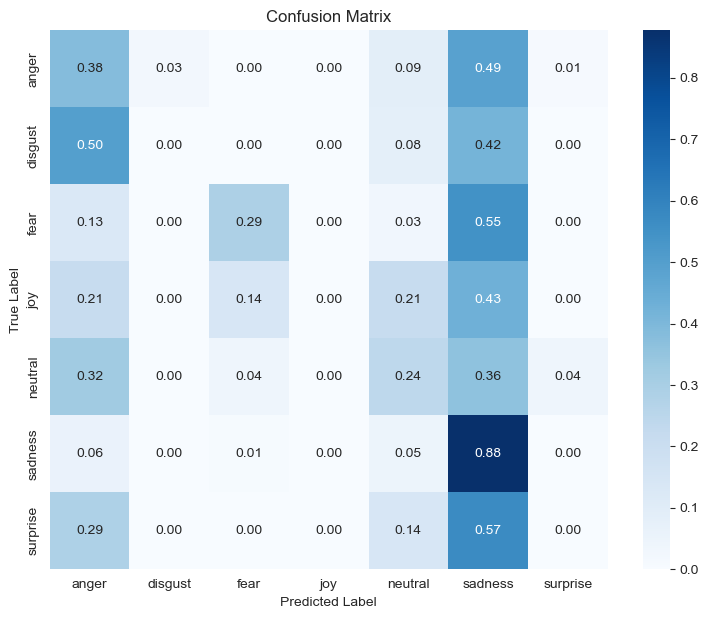

In [245]:
#print classification report
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_og_labels))
#confusion matrix
conf_matrix_og = confusion_matrix(y_true_labels, y_pred_og_labels)
confusionPlot(conf_matrix_og)

# Further exploration with data augmentation

## oversample

Underrepresented categories of emotions do not do well. Therefore, we try to over sample the underrepresented categories. Data augmentation should be done on raw data.

In [201]:
under_represented_classes=[0,1,2,3,4,6] #every category except for sadness
mask_classes = np.isin(train, under_represented_classes)

#resample corpus_train, train with random oversampler
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=RANDOM_SEED)
corpus_train_2d = corpus_train.values.reshape(-1, 1)
train_2d = train.reshape(-1,1)
x_oversampled, y_oversampled = oversampler.fit_resample(corpus_train_2d[mask_classes].reshape(-1, 1), train_2d[mask_classes])

#compile the new x train y train
x_train_oversampled = np.concatenate([corpus_train.values[mask_classes], x_oversampled.flatten()])
y_train_oversampled = np.concatenate([train[mask_classes], y_oversampled])

Same process as before to prep the data

In [202]:
x_train_over = clean_text(x_train_oversampled)
y_train_over = to_categorical(y_train_oversampled, num_classes=len(CATEGORIES))

A new TF-IDF feature extraction is done on the new x train. 

In [252]:
tf_idf_train_over = vectorizer.fit_transform(x_train_over).toarray()

tf_idf_val_over = vectorizer.transform(x_val).toarray()
tf_idf_test_over = vectorizer.transform(x_test).toarray()

Train a new model with the augmented data.

In [253]:
#model: oversample

model_over = Sequential()
model_over.add(Dense(33, activation='relu', input_shape=(tf_idf_train_over.shape[1],)))
model_over.add(Dropout(0.2))
model_over.add(Dense(7, activation='softmax'))

model_over.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
history_over = model_over.fit(tf_idf_train_over, y_train_over, epochs=EPOCH, batch_size=BATCHSIZE, validation_data=(tf_idf_val_over, y_val), callbacks=[EARLY_STOP])
model_over.save(MODEL_LOCATION+'tfidf_over.h5')

Epoch 1/100
23/23 [==============================] - 0s 3ms/step - loss: 1.9292 - accuracy: 0.2124 - val_loss: 1.9651 - val_accuracy: 0.2007
Epoch 2/100
23/23 [==============================] - 0s 1ms/step - loss: 1.8665 - accuracy: 0.3514 - val_loss: 1.9927 - val_accuracy: 0.2348
Epoch 3/100
23/23 [==============================] - 0s 1ms/step - loss: 1.7899 - accuracy: 0.4287 - val_loss: 2.0314 - val_accuracy: 0.2419
Epoch 4/100
23/23 [==============================] - 0s 1ms/step - loss: 1.7009 - accuracy: 0.4940 - val_loss: 2.0775 - val_accuracy: 0.2455
Epoch 5/100
23/23 [==============================] - 0s 1ms/step - loss: 1.6011 - accuracy: 0.5749 - val_loss: 2.1267 - val_accuracy: 0.2670
Epoch 6/100
23/23 [==============================] - 0s 1ms/step - loss: 1.4913 - accuracy: 0.6615 - val_loss: 2.1782 - val_accuracy: 0.2688
Epoch 7/100
23/23 [==============================] - 0s 1ms/step - loss: 1.3743 - accuracy: 0.7166 - val_loss: 2.2349 - val_accuracy: 0.2706
Epoch 8/100
2

9/9 [==============================] - 0s 501us/step


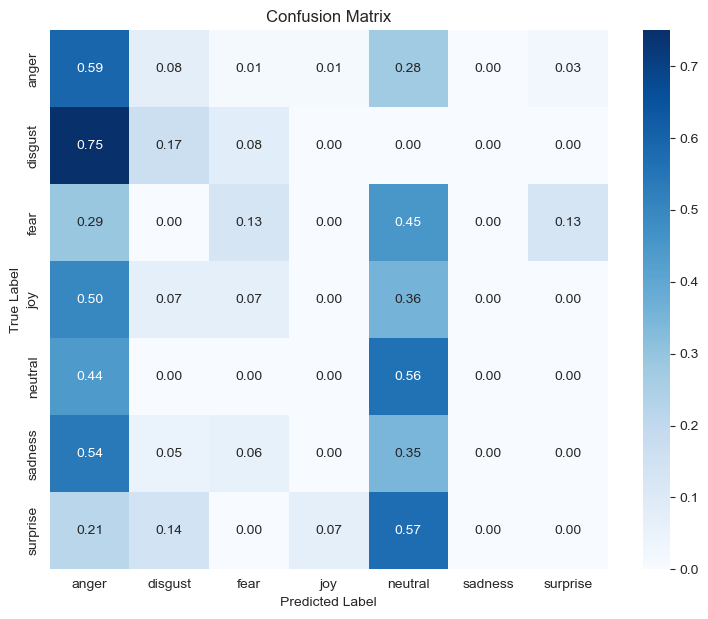


Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.59      0.42        76
           1       0.12      0.17      0.14        12
           2       0.31      0.13      0.18        31
           3       0.00      0.00      0.00        14
           4       0.15      0.56      0.23        25
           5       0.00      0.00      0.00        98
           6       0.00      0.00      0.00        14

    accuracy                           0.24       270
   macro avg       0.13      0.21      0.14       270
weighted avg       0.15      0.24      0.17       270


/Users/ygao/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ygao/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ygao/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [254]:
y_pred_over = model_over.predict(tf_idf_test_over)
y_pred_over_labels = np.argmax(y_pred_over, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
#confusion map
conf_matrix_over = confusion_matrix(y_true_labels, y_pred_over_labels)
confusionPlot(conf_matrix_over)
#print classification report
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_over_labels))

The performance for oversample the underrepresented class did not do so well. 

## Downsample sadness class

Another attempt we did for improving accuracy from a data augmentation perspective is to downsample the overrepresented class: in our case the sadness class. 
The sampling is done on the raw data as well. 

In [255]:
#under sample sadness to have same number to anger
sampling_strategy = {0: len(train[train == 0]), 5: len(train[train == 5])}

undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=RANDOM_SEED)
corpus_train_2d = corpus_train.values.reshape(-1, 1)
train_2d = train.reshape(-1,1)
x_train_undersampled, y_train_undersampled = undersampler.fit_resample(corpus_train_2d, train_2d)

In [256]:
x_train_under = clean_text(x_train_undersampled.flatten())
y_train_under = to_categorical(y_train_undersampled, num_classes=len(CATEGORIES))

Extract new features with TF-IDF on the augmented data. 

In [257]:
tf_idf_train_under = vectorizer.fit_transform(x_train_under).toarray()

tf_idf_val_under = vectorizer.transform(x_val).toarray()
tf_idf_test_under = vectorizer.transform(x_test).toarray()

In [260]:
#model: downsample

model_under = Sequential()
model_under.add(Dense(33, activation='relu', input_shape=(tf_idf_train_under.shape[1],)))
model_under.add(Dropout(0.2))
model_under.add(Dense(7, activation='softmax'))

model_under.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
history_under = model_under.fit(tf_idf_train_under, y_train_under, epochs=EPOCH, batch_size=BATCHSIZE, validation_data=(tf_idf_val_under, y_val), callbacks=[EARLY_STOP])
model_over.save(MODEL_LOCATION+'tfidf_under.h5')

Epoch 1/100
14/14 [==============================] - 0s 5ms/step - loss: 1.9407 - accuracy: 0.1682 - val_loss: 1.9195 - val_accuracy: 0.3369
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 1.9021 - accuracy: 0.3579 - val_loss: 1.8891 - val_accuracy: 0.3584
Epoch 3/100
14/14 [==============================] - 0s 1ms/step - loss: 1.8654 - accuracy: 0.3710 - val_loss: 1.8563 - val_accuracy: 0.3530
Epoch 4/100
14/14 [==============================] - 0s 2ms/step - loss: 1.8239 - accuracy: 0.3587 - val_loss: 1.8213 - val_accuracy: 0.3441
Epoch 5/100
14/14 [==============================] - 0s 2ms/step - loss: 1.7814 - accuracy: 0.3541 - val_loss: 1.7863 - val_accuracy: 0.3441
Epoch 6/100
14/14 [==============================] - 0s 2ms/step - loss: 1.7420 - accuracy: 0.3579 - val_loss: 1.7572 - val_accuracy: 0.3441
Epoch 7/100
14/14 [==============================] - 0s 1ms/step - loss: 1.7013 - accuracy: 0.3541 - val_loss: 1.7321 - val_accuracy: 0.3441
Epoch 8/100
1

Evaluation

9/9 [==============================] - 0s 498us/step

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.36      0.40        76
           1       0.00      0.00      0.00        12
           2       0.80      0.39      0.52        31
           3       0.00      0.00      0.00        14
           4       0.19      0.16      0.17        25
           5       0.52      0.83      0.64        98
           6       0.14      0.07      0.10        14

    accuracy                           0.46       270
   macro avg       0.30      0.26      0.26       270
weighted avg       0.43      0.46      0.42       270


/Users/ygao/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ygao/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ygao/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


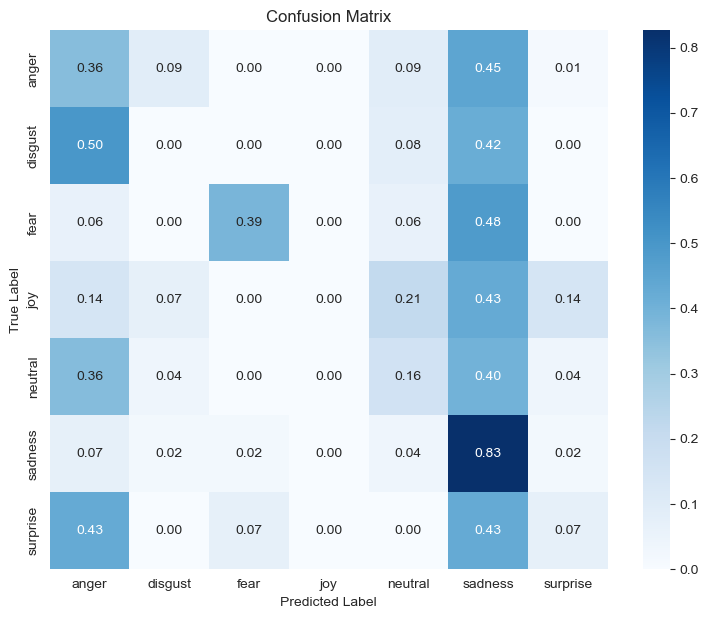

In [261]:
y_pred_under = model_under.predict(tf_idf_test_under)
y_pred_under_labels = np.argmax(y_pred_under, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

#print classification report
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_under_labels))
#confusion map
conf_matrix_under = confusion_matrix(y_true_labels, y_pred_under_labels)
confusionPlot(conf_matrix_under)